### Predictive analysis of Bank Marketing


Problem Statement::
The data is related with direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. 
Often, more than one contact to the same client was required, 
in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

What to achieve? ::
The classification goal is to predict if the client will subscribe a term deposit (variable y).



Data Contains information in following format:
Categorical Variable :
Marital - (Married , Single , Divorced)",
Job - (Management,BlueCollar,Technician,entrepreneur,retired,admin.,services,selfemployed,housemaid,student,unemployed,unknown)
Contact - (Telephone,Cellular,Unknown)
Education - (Primary,Secondary,Tertiary,Unknown)
Month - (Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec)
Poutcome - (Success,Failure,Other,Unknown)
Housing - (Yes/No)
Loan - (Yes/No)
Default - (Yes/No)
Numerical Variable:
Age
Balance
Day
Duration
Campaign
Pdays
Previous
Class
deposit - (Yes/No)

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


#Classification Algorithms 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/harpreet/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Importing Data
data = pd.read_csv("/Users/harpreet/Documents/C_A_ProjReq/C_A_SourceDB/bank (1).csv", delimiter=";",header='infer')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


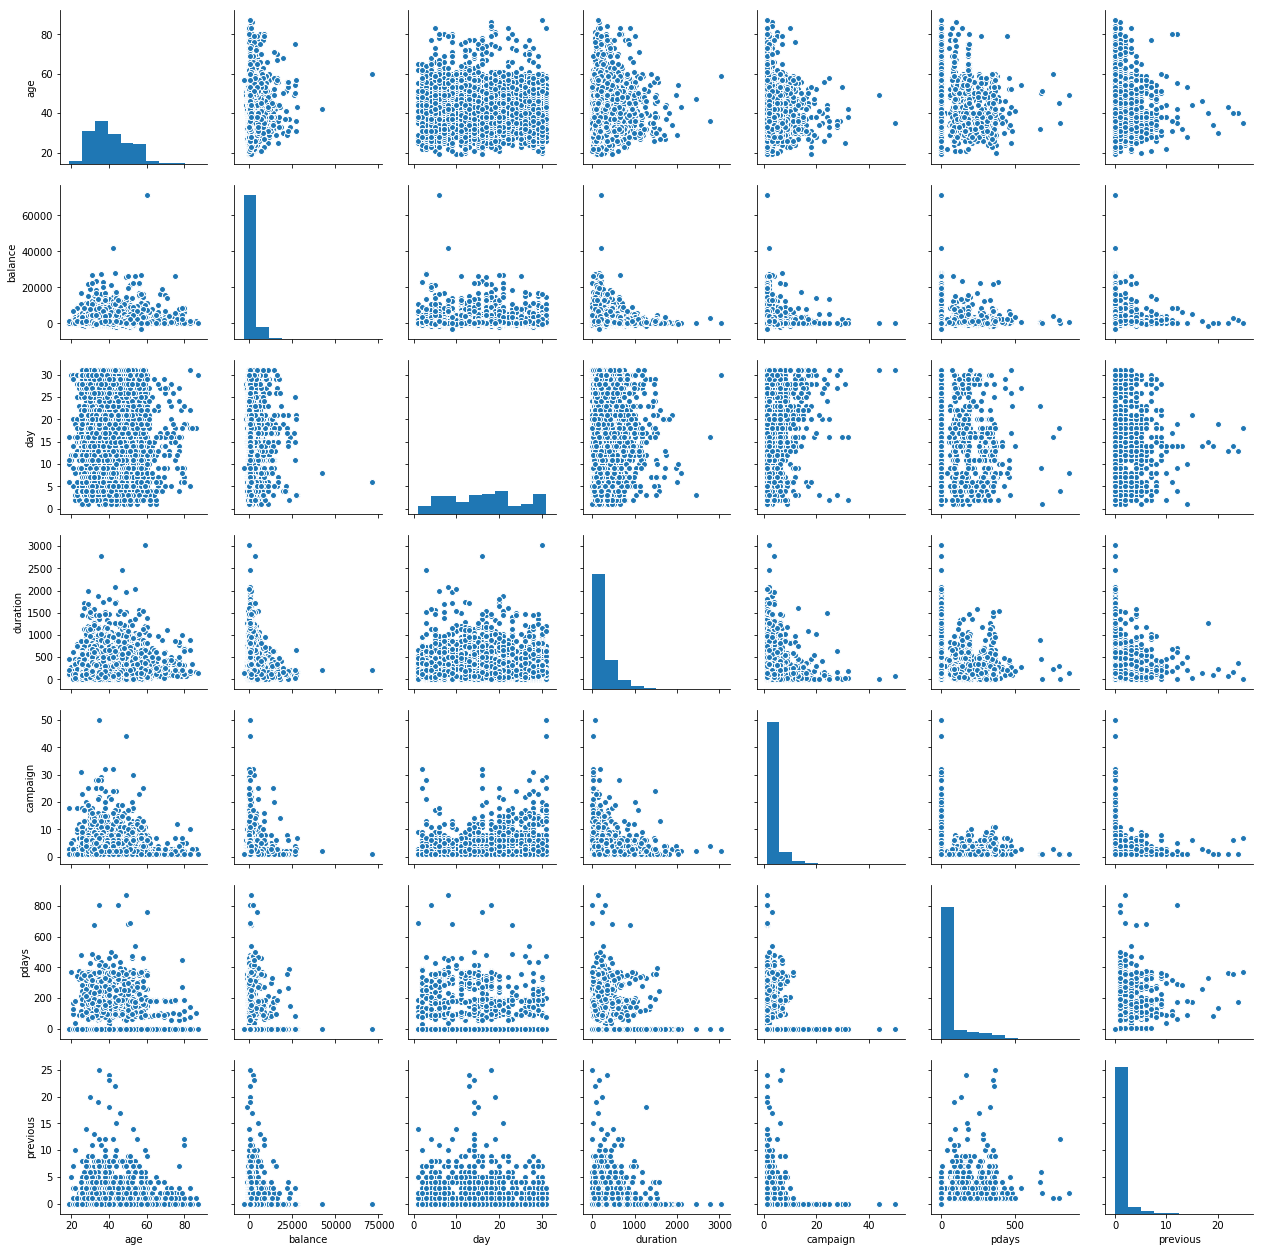

In [4]:
#Finding correlation between features and class for selection

#1. Using Pairplot
sns.pairplot(data)

In [5]:
#We can observe that data here is not-symmetric. 
#So lets find out the correlation matrix to look into details.

#2. Correlation Matrix
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


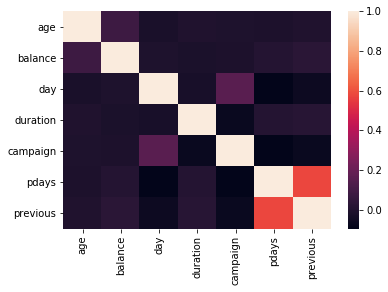

In [6]:
#3. Heatplot to visualise correlation
sns.heatmap(data.corr())

As per the pairplot, correlation matrix, and heatmap, observations as follow:
Data is non-linear, asymmetric
Hence selection of features will not depend upon correlation factor.
Also not a single feature is correlated completely with class, hence requires combinantion of features.

In [7]:
#Encoding Categorical and numerical data into digits form.
#data.dtypes

#Converting object type data into One-Hot Encoded data using get_dummies method.
data_new = pd.get_dummies(data, columns=['job','marital',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome'])

In [8]:
#Class column into binary format
data_new.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [9]:
#Successfully converted data into  integer data types
data_new.dtypes

age                    int64
balance                int64
day                    int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
default_no             uint8
default_yes            uint8
housing_no             uint8
housing_yes            uint8
loan_no                uint8
loan_yes               uint8
contact_cellular       uint8
contact_teleph

In [11]:
#Exploring features: Age as a example

#Whole dataset's shape (ie (rows, cols))
print(data.shape)

#Unique education values
data.education.unique()

(4521, 17)


array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [12]:
#Crosstab to display education stats with respect to y ie class variable
pd.crosstab(index=data["education"], columns=data["y"])


y,no,yes
education,,
primary,614,64
secondary,2061,245
tertiary,1157,193
unknown,168,19


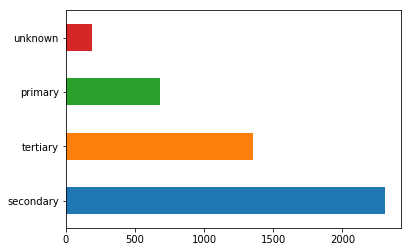

In [13]:
#Education categories and there frequency
data.education.value_counts().plot(kind="barh")

In [14]:
from xgboost import XGBClassifier
classifiers = {
               'Adaptive Boosting Classifier':AdaBoostClassifier(),
               'Linear Discriminant Analysis':LinearDiscriminantAnalysis(),
               'Logistic Regression':LogisticRegression(),
               'Random Forest Classifier': RandomForestClassifier(),
               'K Nearest Neighbour':KNeighborsClassifier(8),
               'Decision Tree Classifier':DecisionTreeClassifier(),
               'Gaussian Naive Bayes Classifier':GaussianNB(),
               'Support Vector Classifier':SVC(),
               }

In [15]:
#Due to one hot encoding increase in the number of columns
data_new.shape

(4521, 52)

In [16]:
data_y = pd.DataFrame(data_new['y'])
data_X = data_new.drop(['y'], axis=1)
print(data_X.columns)
print(data_y.columns)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
Index(['y'], dtype='object')


In [17]:
log_cols = ["Classifier", "Accuracy","Precision Score","Recall Score","F1-Score","roc-auc_Score"]
log = pd.DataFrame(columns=log_cols)

                        Classifier  Accuracy  Precision Score  Recall Score  \
0     Adaptive Boosting Classifier  0.886514         0.713234      0.643062   
0     Adaptive Boosting Classifier  0.899042         0.758238      0.678027   
0     Linear Discriminant Analysis  0.893147         0.736555      0.677486   
0     Linear Discriminant Analysis  0.896094         0.746208      0.684729   
0              Logistic Regression  0.899042         0.775362      0.630618   
0              Logistic Regression  0.896094         0.757756      0.628952   
0         Random Forest Classifier  0.899042         0.777097      0.627829   
0         Random Forest Classifier  0.898305         0.775842      0.621835   
0              K Nearest Neighbour  0.878408         0.644782      0.543663   
0              K Nearest Neighbour  0.887988         0.727635      0.554653   
0         Decision Tree Classifier  0.868828         0.681603      0.691635   
0         Decision Tree Classifier  0.877671        

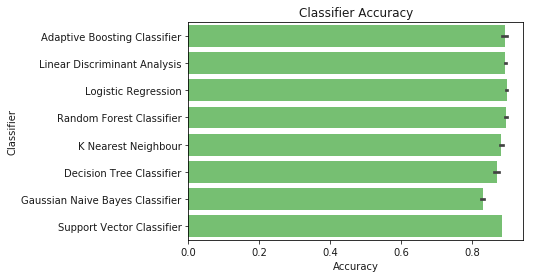

In [21]:
import warnings
warnings.filterwarnings('ignore')
rs = StratifiedShuffleSplit(n_splits=2, test_size=0.3,random_state=2)
rs.get_n_splits(data_X,data_y)
for Name,classify in classifiers.items():
    for train_index, test_index in rs.split(data_X,data_y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X,X_test = data_X.iloc[train_index], data_X.iloc[test_index]
        y,y_test = data_y.iloc[train_index], data_y.iloc[test_index]
        # Scaling of Features 
#         from sklearn.preprocessing import StandardScaler
#         sc_X = StandardScaler()
#         X = sc_X.fit_transform(X)
#         X_test = sc_X.transform(X_test)
        cls = classify
        cls =cls.fit(X,y)
        y_out = cls.predict(X_test)
        accuracy = m.accuracy_score(y_test,y_out)
        precision = m.precision_score(y_test,y_out,average='macro')
        recall = m.recall_score(y_test,y_out,average='macro')
        #roc_auc = roc_auc_score(y_out,y_test)
        f1_score = m.f1_score(y_test,y_out,average='macro')
        log_entry = pd.DataFrame([[Name,accuracy,precision,recall,f1_score,roc_auc]], columns=log_cols)
        #metric_entry = pd.DataFrame([[precision,recall,f1_score,roc_auc]], columns=metrics_cols)
        log = log.append(log_entry)
        #metric = metric.append(metric_entry)
        
print(log)
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="g")  
plt.show()

#Scroll complete output to view all the accuracy scores and bar graph.

As we can see highest accuracy for Logistic Regression.

Why logistic regression?
The models are equivalent in terms of the functions they can express, so with infinite training data and a function where the input variables don't interact with each other in any way they will both probably asymptotically approach the underlying joint probability distribution. This would definitely not be true if your features were not all binary.

Gradient boosted stumps adds extra machinery that sounds like it is irrelevant to your task. Logistic regression will efficiently compute a maximum likelihood estimate assuming that all the inputs are independent. I would go with logistic regression.

In [22]:
#For independent Execution of Logistic Regression, Code as follows:

#Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(3164, 51)
(1357, 51)
(3164, 1)
(1357, 1)


In [23]:
#Create an Logistic classifier and train it on 70% of the data set.
from sklearn import svm
from xgboost import XGBClassifier
clf = LogisticRegression()
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
#Fiting into model
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
#Prediction using test data
y_pred = clf.predict(X_test)

In [26]:
#classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.899042004421518


In [27]:
#Predictions
predictions = clf.predict(X_test)

In [28]:
# Imports
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
print(confusion_matrix(y_test, predictions))

# New line
print('\n')

# Classification report
print(classification_report(y_test,predictions))

[[1176   25]
 [ 112   44]]


             precision    recall  f1-score   support

          0       0.91      0.98      0.94      1201
          1       0.64      0.28      0.39       156

avg / total       0.88      0.90      0.88      1357

